In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sympy as sym
from sympy import symbols, simplify, trigsimp, expand
from matplotlib import pyplot as plt


from Calculation.geometry_util import pol2cart, cart2pol, r_ort, tet_ort, phi_ort
from Calculation.material import StaticMaterial, Material, LayeredFilm, Hk2KuJ, print_Hext_parameters

In [2]:
from Calculation.StationaryState import StationaryState   
        
st_state = StationaryState()

In [19]:
from Calculation.LinearSingle import LinearSingle

linear_single = LinearSingle()

In [22]:
simplify(linear_single.f_K_eq**2)

H*gamma**2*(H*Ms*cos(theta_H - theta_M) - 4*K_u1*sin(theta_M)**2 + 2*K_u1 - 16*K_u2*sin(theta_M)**4 + 12*K_u2*sin(theta_M)**2 + 8*pi*Ms**2*sin(theta_M)**2 - 4*pi*Ms**2)*sin(theta_H)/(4*pi**2*Ms*(alpha**2 + 1)*sin(theta_M))

In [4]:
from Calculation.LinearDouble import LinearDouble

linear_double = LinearDouble()

In [5]:
mu0 = 1.2566370621219e-6

uB_SI = 9.274009994e-24 #J/T
uB_CGS = 9.274009994e-21 #erg/G

hb_SI = 1.054571817e-34 # J*s
hb_CGS = 1.054571817e-27 #erg*s

g0_SI = uB_SI/hb_SI #1/(T*s)
g0_CGS = uB_CGS/hb_CGS #1/(G*s)

In [6]:
H1k1 = 7.5e3
H1k2 = 6.5e3
H2k = 12.5e3

thickness = 12e-7
Ms_hyst = 620.

Ku_1ord, Ku_2ord, J_hyst = Hk2KuJ(H1k1, H1k2, H2k, Ms_hyst, thickness)

#setting up film parameters
film_inst_single = LayeredFilm.from_file('default_single')
film_inst_double = LayeredFilm.from_file('default_double')

film_inst_single.update_with_Hk(H1k1, H1k2, H2k, Ms_hyst, zeroJ=True)
film_inst_double.update_with_Hk(H1k1, H1k2, H2k, Ms_hyst, zeroJ=False)


print("single layered")
film_inst_single.print()
print("double layered")
film_inst_double.print()

single layered
---------------------------------------------------
sample parametrs:
	J = 0.00

	layer1 parameters:
	PdFe
		Ku_1ord = 2.73e+06
		Ku_2ord = 1.01e+06
		Ms = 620.00
		t = 1.20e-06
		gamma = 1.86e+07
		alpha = 0.1000

	layer2 parameters:
	PdFe
		Ku_1ord = 2.73e+06
		Ku_2ord = 1.01e+06
		Ms = 620.00
		t = 1.20e-06
		gamma = 1.86e+07
		alpha = 0.1000
---------------------------------------------------
double layered
---------------------------------------------------
sample parametrs:
	J = 1.86

	layer1 parameters:
	PdFe
		Ku_1ord = 2.73e+06
		Ku_2ord = 1.01e+06
		Ms = 620.00
		t = 1.20e-06
		gamma = 1.86e+07
		alpha = 0.1000

	layer2 parameters:
	PdFe
		Ku_1ord = 2.73e+06
		Ku_2ord = 1.01e+06
		Ms = 620.00
		t = 1.20e-06
		gamma = 1.86e+07
		alpha = 0.1000
---------------------------------------------------


In [14]:
%matplotlib notebook
class LinearSingleResults:
    def __init__(self, film_inst):
        Htet = np.deg2rad(63.)
        Habses = np.linspace(1e3, 6e3, 100)
        self.Hax = Habses
        
        self.res_ang_min = []
        self.res_ang_max = []
        self.res_freq_min = []
        self.res_freq_max = []
        self.res_tau = []
        
        
        for Habs in Habses:
            Hext = pol2cart(Habs, Htet, 0.)
            
            angles = st_state.get_angles_optimize(
                film_inst,
                Hext,
                tol=1e-8,
            )
            Mtet0_min = min(angles[0], angles[2])
            Mtet0_max = max(angles[0], angles[2])
            
            self.res_ang_min.append(Mtet0_min)
            self.res_ang_max.append(Mtet0_max)
            
            self.res_freq_min.append(
                linear_single.freq(Habs, Htet, Mtet0_min, H1k1, H1k2, film_inst.l1.st.gamma, film_inst.l1.st.alpha)
            )
            self.res_freq_max.append(
                linear_single.freq(Habs, Htet, Mtet0_max, H1k1, H1k2, film_inst.l1.st.gamma, film_inst.l1.st.alpha)
            )
            self.res_tau.append(
                linear_single.tau(Habs, Htet, Mtet0_min, H1k1, H1k2, film_inst.l1.st.gamma, film_inst.l1.st.alpha)
            )

results_single = LinearSingleResults(film_inst_single)
    

In [8]:
class LinearDoubleResults:
    def __init__(self, film_inst):
        Htet = np.deg2rad(63.)
        Habses = np.linspace(1e3, 6e3, 100)
        self.Hax = Habses
        
        self.res_freq = []
        
        for res_lamb in linear_double.f_res_lamb:
            res_freq_tmp = []
            for Habs in Habses:
                Hext = pol2cart(Habs, Htet, 0.)
                
                angles = st_state.get_angles_optimize(
                    film_inst,
                    Hext,
                    tol=1e-8
                )
                
                res_freq_tmp.append(
                    res_lamb(
                        Habs, Htet,
                        film_inst.l1.st.Ms, angles[0], angles[2],
                        H1k1, H1k2, H2k,
                        film_inst.l1.st.t,
                        film_inst.l1.st.gamma
                    )
                )
            self.res_freq.append(res_freq_tmp)
            
        
results_double = LinearDoubleResults(film_inst_double)

In [9]:
H_xl = np.array([
    1.5,
    2.3,
    3,
    3.8,
    4.6
])

f_num_s = np.array([
    10.74,
    14.15,
    16.4,
    18.78,
    21
])

f_num_d = np.array([
    8.18,
    9.8,
    10.96,
    12.1,
    12.67
])

f_exp_s = np.array([
    11.82,
    12.46,
    13.13,
    14.22,
    15.36
])

f_exp_d = np.array([
    8.46,
    9.83,
    10.95,
    12.09,
    12.72
])



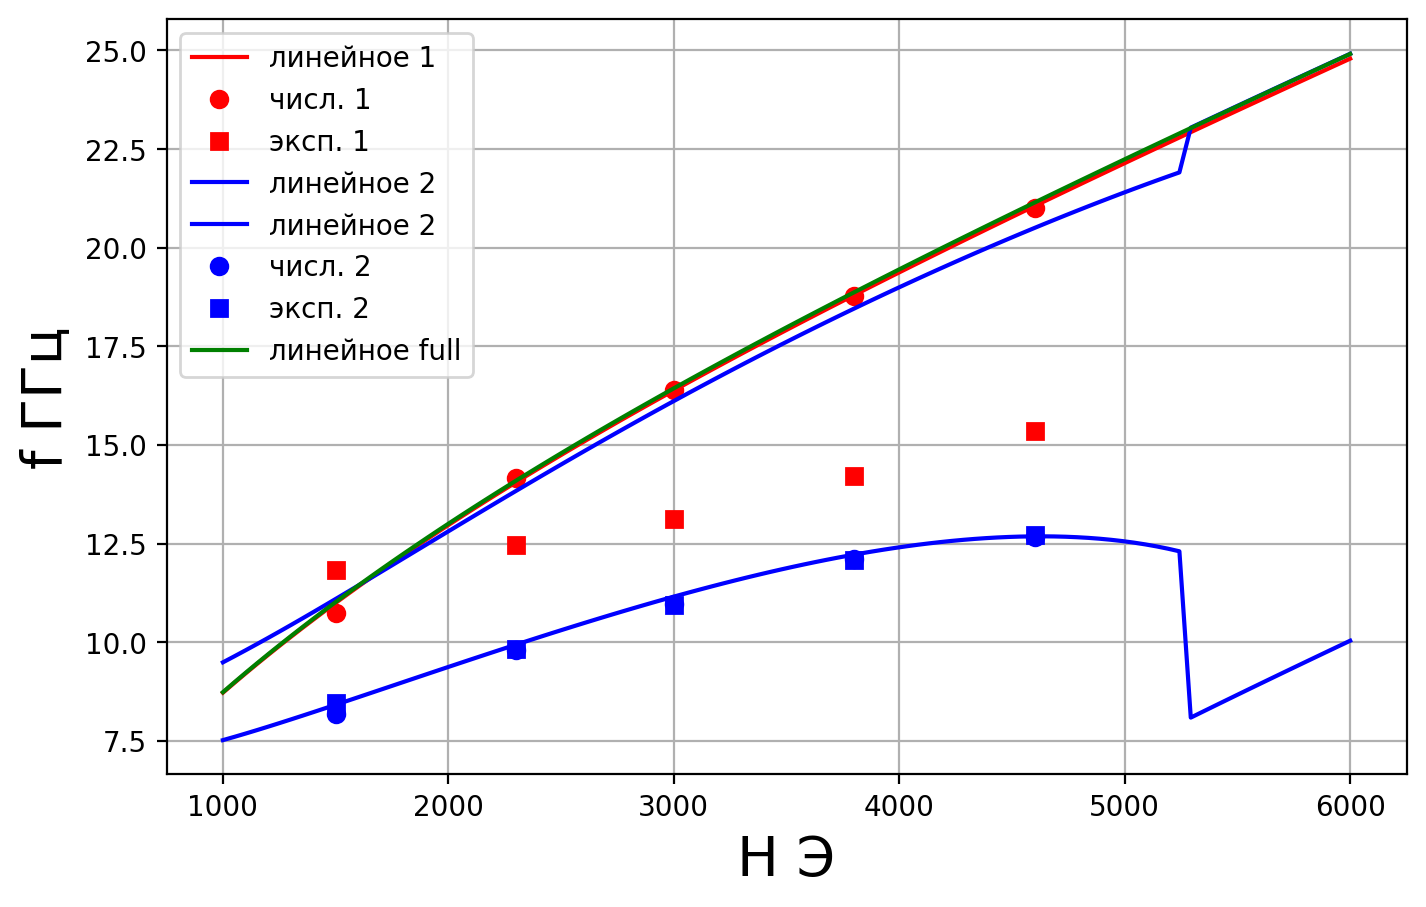

In [15]:
%matplotlib inline
plt.figure(figsize=(8, 5), dpi=200)

plt.plot(results_single.Hax, np.array(results_single.res_freq_min)*1e-9, 'r-', label="линейное 1")
plt.plot(H_xl * 1e3, f_num_s, 'ro', label='числ. 1')
plt.plot(H_xl * 1e3, f_exp_s, 'rs', label='эксп. 1')

plt.plot(results_double.Hax, np.array(results_double.res_freq[1])*1e-9, 'b-', label="линейное 2")
plt.plot(results_double.Hax, np.array(results_double.res_freq[3])*1e-9, 'b-', label="линейное 2")
plt.plot(H_xl * 1e3, f_num_d, 'bo', label='числ. 2')
plt.plot(H_xl * 1e3, f_exp_d, 'bs', label='эксп. 2')

plt.grid()
plt.xlabel("H Э", fontsize=20)
plt.ylabel("f ГГц", fontsize=20)

plt.legend(fontsize=10)


In [27]:
tau_num_s = np.array([
    109.8,
    84.0,
    76.6,
    71.2,
    64.9
])

tau_exp_s = np.array([
    88,
    77,
    79,
    85,
    94
])

tau_num_d = np.array([
    110.2,
    89.7,
    85.5,
    87.1,
    92.2
])

tau_exp_d = np.array([
    0,0,0,0,0
])

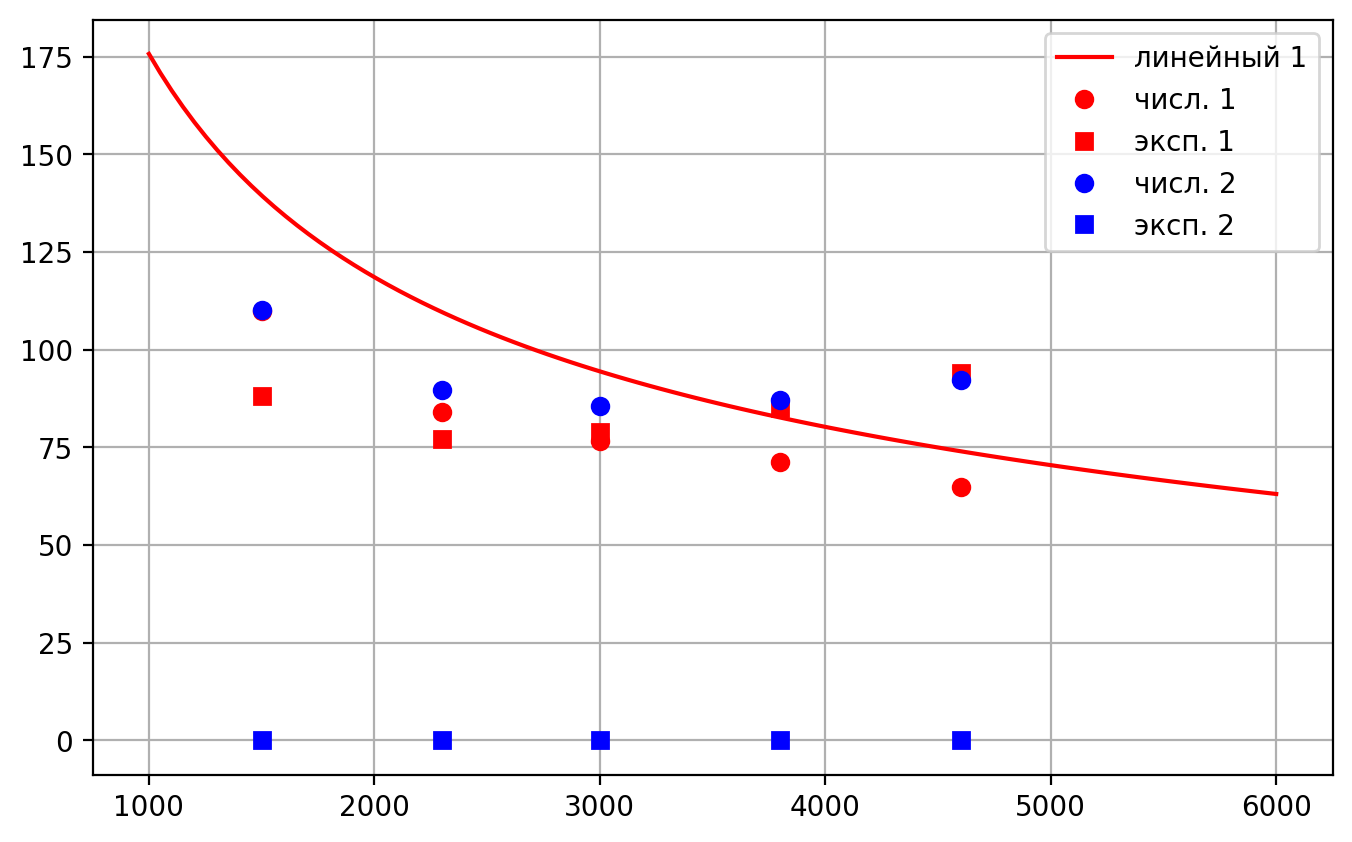

In [35]:
%matplotlib inline
plt.figure(figsize=(8, 5), dpi=200)

plt.plot(results_single.Hax, np.array(results_single.res_tau)*1e12, 'r-', label='линейный 1')
plt.plot(H_xl * 1e3, tau_num_s, 'ro', label='числ. 1')
plt.plot(H_xl * 1e3, tau_exp_s, 'rs', label='эксп. 1')

#plt.plot(results_single.Hax, np.array(results_single.res_tau)*1e12, 'r-', label='линейный 1')
plt.plot(H_xl * 1e3, tau_num_d, 'bo', label='числ. 2')
plt.plot(H_xl * 1e3, tau_exp_d, 'bs', label='эксп. 2')

plt.grid(True)
plt.legend()

In [ ]:
%matplotlib notebook
plt.plot(Habses, np.rad2deg(res_ang), label='min')
plt.plot(Habses, np.rad2deg(res_ang_max), label='max')
plt.grid(True)
plt.legend()

In [17]:
simplify(linear_double.f_eq[1].subs({symbols("theta_H"): np.deg2rad(90), symbols("theta_M2"):sym.pi - symbols("theta_M1")}))


KeyboardInterrupt: 